#### Setup

Previously, we mentioned that

If we could generate virtual samples from the kernel matrix `over the entire input space` (all training and testing points), then the covariance structure among all data points would be properly accounted for. However, this is very inefficient computationally, even if it is not infeasible

The computational problem comes from the fact that the full kernel matrix can be huge

Here, we look at how Nystrom method can help to alleviate the problem

#### Nystrom approximation of kernel matrices

For our kernel matrix $X_k$, we can divide it up into 4 quandrants

$$X_k =\begin{bmatrix}A &B^T \\ B &C\end{bmatrix}$$

where the size of $A$ is much smaller than the size of $C$

The idea of Nystrom method is that by calculating just sub-portion $A$ and $B$, we can approximate the entire $X_k$ and we don't need to compute and store the full $X_k$ (which can be very large, as mentioned)

More precisely, the method makes assumption that for $X_k$ of size $n \times n$, it only has $m \ll n$ non-zero eigenvalues in practical sense, and therefore, we can avoid having to work with the full $n \times n$ matrix

#### Approximate $C$

Let's say we have a scheme to pick $m$ data points (random sampling turns out to be good) out of $n$ to form a smaller kernel matrix $A$ with $m$ non-zero eigenvalues

Since $X_k$ is `symmetric`, we know it has an `eigendecomposition` (removing all zero eigenvalues in practical sense) such that

$$\begin{align*}
X_k&\approx U\Lambda U^T \\
&=\begin{bmatrix}U_1\\U_2\end{bmatrix} \Lambda \begin{bmatrix}U_1\\U_2\end{bmatrix}^T \\
&=\begin{bmatrix}U_1\Lambda U_1^T & U_1\Lambda U_2^T \\U_2\Lambda U_1^T & U_2\Lambda U_2^T\end{bmatrix}
\end{align*}$$

where $U_1$ is $m \times m$ and $U_2$ is $(n-m) \times m$, therefore, the sizes match $A, B, C$

If $U_1$ is `invertible` (which it almost always is under random scheme), then

$$A^{-1}=U_1^{-T}\Lambda^{-1}U_1^{-1}$$

and we have

$$BA^{-1}B^T=U_2\Lambda U_1^TU_1^{-T}\Lambda^{-1}U_1^{-1}U_1\Lambda U_2^T=U_2\Lambda U_2^T=C$$

#### Virtual samples

Of course, we never want to compute $C$ directly

Instead, we can write

$$C=BA^{-1}B^T=\left(BA^{-\frac{1}{2}}\right)\left(BA^{-\frac{1}{2}}\right)^T$$

If we define

$$F=\begin{bmatrix}A^{\frac{1}{2}} \\ BA^{-\frac{1}{2}}\end{bmatrix}$$

we can see that

$$\begin{align*}FF^T&=\begin{bmatrix}A^{\frac{1}{2}} \\ BA^{-\frac{1}{2}}\end{bmatrix}\begin{bmatrix}A^{\frac{1}{2}} \\ BA^{-\frac{1}{2}}\end{bmatrix}^T \\
&=\begin{bmatrix}A^{\frac{1}{2}} A^{\frac{1}{2}} & A^{\frac{1}{2}} A^{-\frac{1}{2}}B^T\\ BA^{-\frac{1}{2}}A^{\frac{1}{2}} & BA^{-\frac{1}{2}}A^{-\frac{1}{2}}B^T\end{bmatrix} \\
&=\begin{bmatrix}A & B^T\\ B & BA^{-1}B^T\end{bmatrix} \\
\end{align*}$$

Therefore, the rows of $F$ can be chosen as virtual samples, and the above expression shows that the dot product approximates the kernel matrix $X_k$

Slightly rewrite $F$ as

$$F=\begin{bmatrix}A^{\frac{1}{2}} \\ BA^{-\frac{1}{2}}\end{bmatrix}=\begin{bmatrix}A \\ B\end{bmatrix}A^{-\frac{1}{2}}$$

We see that under the hood, we actually approximate $X_k$ as

$$\boxed{X_k=\begin{bmatrix}A \\ B\end{bmatrix}A^{-1}\begin{bmatrix}A \\ B\end{bmatrix}^T}$$

Now we can obtain virtual sample for individual data points

This is exactly the same for training and for testing data point $x_i$, and the virtual sample is

$$\boxed{\phi(x_i)=\begin{bmatrix}k(x_i, x_1) & \cdots & k(x_i, x_m)\end{bmatrix}A^{-\frac{1}{2}}}$$

where $x_1, \cdots, x_m$ are $m$ sampled point to construct $A$

Finally question is how to compute $A^{-\frac{1}{2}}$?

If $A$ has non-zero, distinct eigenvalues, then it is invertible and diagonalizable

Recall that diagonalization can simplify many computations, including power

$$\begin{align*}
A^k =U'\text{diag}\left(\lambda_1^k,\cdots,\lambda_n^k\right)U'^{T}
\end{align*}$$

Therefore, using eigendecomposition of $A$ itself, we have

$$A^{-\frac{1}{2}}=U'\Lambda'^{-\frac{1}{2}} U'^T$$

We can verify how well virtual samples from Nystrom approximation can match the correlation based on the true RBF kernel function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
plt.style.use('dark_background')

In [3]:
def rbf_kernel_vectorized(x_set_1, x_set_2, sigma_k):
    diff = x_set_1[:, None, :] - x_set_2[None, :, :]
    l2 = np.sum((diff / sigma_k) ** 2, axis=2)
    k_mat = np.exp(-0.5 * l2)

    return k_mat

def rbf_nystrom_comparison(idx, d=1, m=30, n=100, sigma=1.):
    x = np.linspace(0, 6, n) # n: number of data
    m = m # number of virtual samples

    # randomly select m from x
    x_m_idx = np.random.choice(np.arange(n), m, replace=False)
    x_m = x[x_m_idx]

    A = rbf_kernel_vectorized(x_m.reshape(-1, 1), x_m.reshape(-1, 1), sigma)
    B = rbf_kernel_vectorized(x.reshape(-1, 1), x_m.reshape(-1, 1), sigma)

    eigvals, eigvecs = np.linalg.eigh(A)
    eigvals[eigvals < 1e-10] = 0

    # A^{-1/2}
    eigvals_sqrt_inv = np.diag(1.0 / np.sqrt(eigvals[eigvals > 1e-10]))
    eigvecs_trunc = eigvecs[:, eigvals > 1e-10]
    A_inv_sqrt = eigvecs_trunc @ eigvals_sqrt_inv @ eigvecs_trunc.T

    phi_x = B @ A_inv_sqrt  # virtual samples for all x
    phi_x_m = phi_x[x_m_idx]  # virtual samples for x_m

    # select an anchor point x_a
    x_a = x[idx]

    # RBF function between x and x_a
    k_true = rbf_kernel_vectorized(x.reshape(-1, 1), x_a.reshape(1, -1), sigma).flatten()

    # Nystrom: phi(x)^T phi(x_a)
    phi_x_a = phi_x[idx]  # virtual sample for anchor point
    k_approx = phi_x @ phi_x_a

    error = np.linalg.norm(k_true - k_approx) / np.linalg.norm(k_true)
    print(f"Approximation error: {error:.6f}")

    plt.figure(figsize=(8,4))
    plt.plot(x, k_true, 'm', linewidth=2, label='RBF function')
    plt.plot(x, k_approx, 'c', linewidth=2, label='Nystrom approximation')
    plt.legend()
    plt.show()

Approximation error: 0.053698


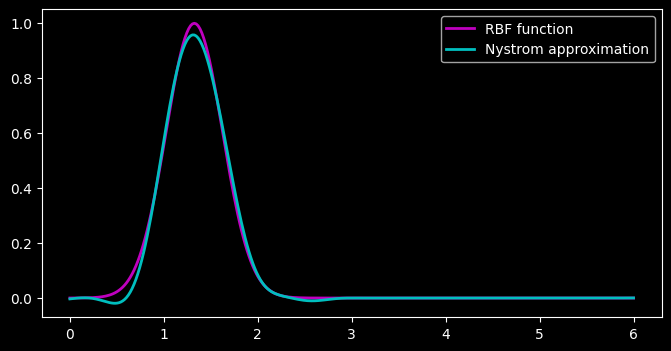

In [8]:
np.random.seed(42)

rbf_nystrom_comparison(d=1, m=25, n=300, sigma=0.3, idx=200//3)